In [1]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import random
import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import defaultdict
pio.renderers.default = 'notebook_connected'

import os
sns.set()

if 'notebook' in os.getcwd():
    os.chdir('..')

import gym
import gym.envs.toy_text
import copy 
import io
import base64
import glob
from IPython.display import HTML

# Temporal Differencing (TD)

An approach that combines the benifits of Dynamic Programming (DP) and Monte Carlo (MC) by using bootstrapping from DP and the sample-based approach from MC. Below is the implementation of TD(0) where the 0 refers to one less than how many future states are discounted.

$$ V'(s) = V(s) + \alpha[R + \lambda V(s') - V(s)]$$
$$ Q'(s,a) = Q(s,a) + \alpha[R + \lambda Q(s',a') - Q(s',a')]$$

where:
- $V(s)$: Current value of a state
- $V'(s)$: New value of a state
- $s$: current state
- $s'$: next state after an action is taken
- $\alpha$: learning rate
- $a$: action
- $\lambda$: discount factor

### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Atari games and others.

In [2]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

e:\Public\Repos\venv\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning:

[WinError -2147417850] Cannot change thread mode after it is set



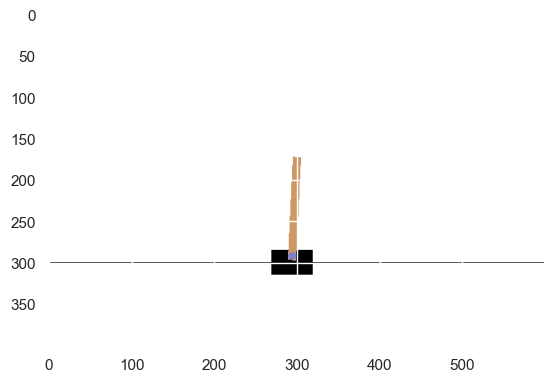

In [3]:
env_name = 'CartPole-v1'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
env.close()
state_shape, n_actions = env.observation_space.shape, env.action_space.n

In [4]:
def discretize_observation(x):
    """Discretizes the observation space to a fixed number of bins."""
    
    # Please change me
    max_v = 10_000
    n_bins = 100
    
    x = np.clip(x, -max_v, max_v)
    x_max = np.clip(env.observation_space.high, -max_v, max_v)
    x_min = np.clip(env.observation_space.low, -max_v, max_v)
    
    x = (x - x_min) / (x_max - x_min)
    
    return tuple([int(xi * n_bins) for xi in x])

In [5]:
discretize_observation(env.reset())

(49, 50, 47, 49)

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden layers with Relu activation and final layer being logits with dimension equal to number of actions. 

# State-Actio-Reward-State-Action (SARSA)

This is in on-policy control algorithm. It sample step by step and updates the Q values where the learning rate can be controlled. 

In [8]:
# SARSA Learning agent class

class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        """ Implementation of a SARSA model.

        Args:
            alpha (float): Learning rate when updating the Q values.
            epsilon (float): Probability to produce random action.
            gamma (flaot): Discount factor
            get_possible_actions (list): List of possible actions to return.
        """
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0)) # Q-values of unseen state-action pairs default to 0.

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        # Implement temporal differencing
        if not done:
            # Calculate future discounted reward
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            # No future discounter reward
            td_error = reward - self.get_Q(state, action)

        # Update Q-value
        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [9]:
# training algorithm
def train_sarsa_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        state = discretize_observation(state)
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_observation(next_state)
            
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [10]:
# plot rewards
def plot_rewards(env_name, rewards, label, n = 20):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-n:])))
    rewards_mean = np.array([np.nan] * len(rewards))
    for i in range(n,len(rewards)):
        rewards_mean[i] = rewards[i-n:i].mean()
    plt.plot(rewards, label=label)
    plt.plot(rewards_mean, label=label + '_mean')
    plt.grid()
    plt.legend()
    plt.show()

In [11]:
# create a SARSA agent
sarsa_agent = SARSAAgent(
            alpha=0.2,
            epsilon=0.2,
            gamma=0.995,
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_sarsa_agent(env, sarsa_agent, episode_cnt = 1000)

In [12]:
print('Total number of visited states:',len(sarsa_agent._Q))

Total number of visited states: 1180


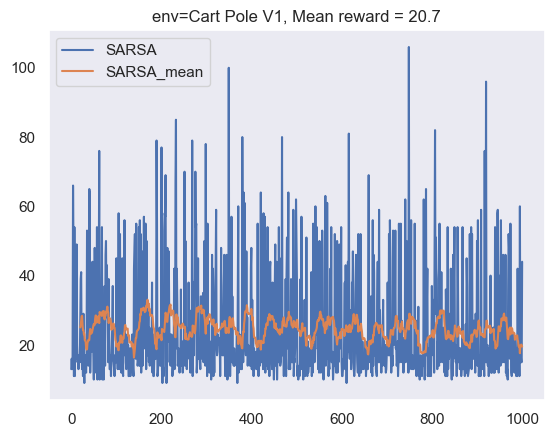

In [13]:
# plot rewards
plot_rewards("Cart Pole V1", rewards, 'SARSA')

**Let us record a video of trained agent**

In [14]:
def generate_animation(env, agent, save_dir):
    
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    reward = 0
    while True:
        state = discretize_observation(state)
        action = agent.get_action(state)
        state, r, done, _ = env.step(action)
        reward += r
        if done:
            print('Got reward: {}'.format(reward))
            break
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [16]:
# Animate learned policy
save_dir='data/07_model_output/sarsa/v0'
env = make_env(env_name)
generate_animation(env, sarsa_agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Got reward: 41.0


# Q-Learning

This is in on-policy control algorithm. It sample step by step and updates the Q values where the learning rate can be controlled. 

In [17]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        """ Implementation of a Q-learning model.

        Args:
            alpha (float): Learning rate when updating the Q values.
            epsilon (float): Probability to produce random action.
            gamma (flaot): Discount factor
            get_possible_actions (list): List of possible actions to return.
        """
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, best_next_action) \
                       - self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [18]:
# training algorithm
def train_q_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=0.99):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        state = discretize_observation(state)
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_observation(next_state)
            agent.update(state, action, reward, next_state, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                agent.epsilon = agent.epsilon * anneal_eps
                break
            state = next_state
    return np.array(episode_rewards)

In [19]:
# create a Q Learning agent
alpha=0.2
epsilon=0.2
q_agent = QLearningAgent(alpha=alpha, epsilon=epsilon, gamma=0.9995, 
                       get_possible_actions=lambda s : range(env.action_space.n))

#train agent and get rewards for episodes
min_epsilon = 0.1
episode_cnt = 1000
anneal_eps = (min_epsilon / epsilon) ** (1/episode_cnt)

rewards = train_q_agent(env, q_agent, episode_cnt = episode_cnt, anneal_eps = anneal_eps)

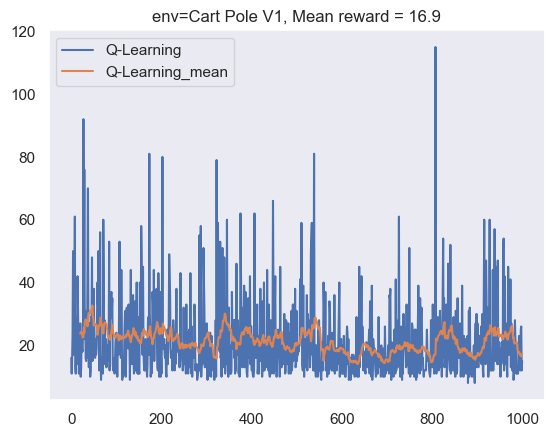

In [20]:
# Plot rewards
plot_rewards("Cart Pole V1",rewards, 'Q-Learning')

In [21]:
# Animate learned policy
save_dir='data/07_model_output/qlearning/v0/'
env = make_env(env_name)
generate_animation(env, q_agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Got reward: 10.0


## Hyperparameter Tuning

In [22]:
import optuna
from optuna.visualization import *

e:\Public\Repos\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [23]:
env_run = copy.deepcopy(env)

In [24]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 5e-1) #trial.suggest_float("alpha", 1e-6, 5e-1, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-6, 9e-1) #trial.suggest_float("epsilon", 1e-6, 9e-1, log=True)
    
    # create a Q Learning agent
    q_agent = QLearningAgent(alpha=alpha, epsilon=epsilon, gamma=0.9995,
                        get_possible_actions=lambda s : range(env.action_space.n))

    #train agent and get rewards for episodes
    min_epsilon = 0.1
    episode_cnt = 300
    anneal_eps = (min_epsilon / epsilon) ** (1/episode_cnt)
    train_q_agent(env, q_agent, episode_cnt = episode_cnt, anneal_eps = anneal_eps)
    
    # Evaluate Agent
    tmax = 10000
    G = 0

    state = env_run.reset()
    q_agent.epsilon = -1.0
    for t in range(tmax):
        state = discretize_observation(state)
        action = q_agent.get_action(state)

        next_state, reward, done, _ = env_run.step(action)
        G += reward
        if done:
            break
        state = next_state
    return G

In [25]:
study = optuna.create_study(direction = 'maximize')

[I 2023-07-16 22:06:17,791] A new study created in memory with name: no-name-ef443c41-ec60-4263-872b-37eadaf6473d


In [26]:
study.optimize(objective, n_trials = 100)

[I 2023-07-16 22:06:18,953] Trial 0 finished with value: 39.0 and parameters: {'alpha': 0.3271223484246879, 'epsilon': 0.10994306877622484}. Best is trial 0 with value: 39.0.
[I 2023-07-16 22:06:19,580] Trial 1 finished with value: 11.0 and parameters: {'alpha': 0.26234741960137326, 'epsilon': 0.5139704838675324}. Best is trial 0 with value: 39.0.
[I 2023-07-16 22:06:20,149] Trial 2 finished with value: 14.0 and parameters: {'alpha': 0.4016879682234055, 'epsilon': 0.5753485915276266}. Best is trial 0 with value: 39.0.
[I 2023-07-16 22:06:20,838] Trial 3 finished with value: 18.0 and parameters: {'alpha': 0.09282729099210771, 'epsilon': 0.4816614186186314}. Best is trial 0 with value: 39.0.
[I 2023-07-16 22:06:21,314] Trial 4 finished with value: 13.0 and parameters: {'alpha': 0.4101412919419192, 'epsilon': 0.4139851050999244}. Best is trial 0 with value: 39.0.
[I 2023-07-16 22:06:21,871] Trial 5 finished with value: 11.0 and parameters: {'alpha': 0.4333058315079842, 'epsilon': 0.671508

In [27]:
fig = plot_parallel_coordinate(study)
fig.show()

In [28]:
fig = plot_param_importances(study)
fig.show()

In [29]:
optuna.visualization.plot_contour(study, params=['alpha', 'epsilon'])

In [30]:
trial = study.best_trial

print('Best trial value:', trial.value)
for key, value in trial.params.items():
    print(f'{key} = {value},')

Best trial value: 112.0
alpha = 0.021000398634307627,
epsilon = 0.6323703119604186,


In [43]:
selected_params = dict(
                    alpha = 0.1,
                    epsilon = 0.999, #04967641959074442,
                    anneal_eps = 0.997,
                    )
# selected_params = trial.params

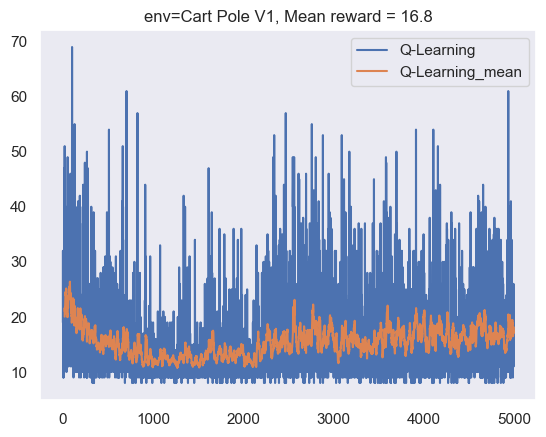

In [44]:
# create a Q Learning agent
q_agent = QLearningAgent(alpha = selected_params['alpha'], 
                         epsilon = selected_params['epsilon'], 
                         gamma=0.9995, 
                       get_possible_actions=lambda s : range(env.action_space.n),
                       )

#train agent and get rewards for episodes
min_epsilon = 0.01
episode_cnt = 5000
anneal_eps = (min_epsilon / selected_params['epsilon']) ** (1/episode_cnt)
rewards = train_q_agent(env, q_agent, episode_cnt = episode_cnt, 
                        anneal_eps = anneal_eps,
                        )

# Plot rewards
plot_rewards("Cart Pole V1",rewards, 'Q-Learning')

In [45]:
print('Total number of visited states:', len(q_agent._Q))

Total number of visited states: 587


In [46]:
# Animate learned policy
save_dir='data/07_model_output/qlearning/v1/'
env = make_env(env_name)
generate_animation(env, q_agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Got reward: 13.0


In [184]:
tmax = 10000
G = 0

env_run = copy.deepcopy(env)
state = env_run.reset()
q_agent.epsilon = 0.0
for t in range(tmax):
    env_run.render(mode = 'human')
    
    state = discretize_observation(state)
    action = q_agent.get_action(state)

    next_state, reward, done, _ = env_run.step(action)
    G += reward
    if done:
        break
    state = next_state

    time.sleep(0.1)

print(f'lasted for {t} steps with a score of {G}')
env_run.close()

lasted for 165 steps with a score of 166.0


### Save Q table

In [176]:
import pickle as pkl

foldername = 'data/06_model/qlearning'
if not os.path.exists(foldername):
    os.mkdir(foldername)

In [180]:
def convert_to_dict(x):
    out = {}
    for key, value in x.items():
        if isinstance(value, (bool, int, float)): 
            out[key] = value
        else:
            out[key] = convert_to_dict(value)
    return out

In [183]:
with open(os.path.join(foldername, 'q_learning_model_v2.pkl'), 'wb') as file:
    pkl.dump(convert_to_dict(q_agent._Q), file)

# Summary